## 11.6 Lab: Eigenfaces

**Task 11.6.1:** Load the twenty face images into Python, and construct a dictionary mapping the integers 0 through 19 to `Vec`s representing the images.

In [1]:
import sys
sys.path.append('../')

from image import file2image, color2gray
from vec import Vec
from vecutil import list2vec

# image represented as 2d list
def image2vec(image):
    w = len(image[0])
    h = len(image)
    return Vec({(x, y) for x in range(w) for y in range(h)}, {(x,y): image[y][x] for x in range(w) for y in range(h)})

def vec2image(vec):
    return [[vec[(x, y)] for x in range(max(vec.D, key=lambda item:item[0])[0])] for y in range(max(vec.D, key=lambda item:item[1])[1])]

face_images = {i: image2vec(color2gray(file2image("faces/img%02d.png" % i))) for i in range(20)}

**Task 11.6.2:** Compute the centroid $\boldsymbol{a}$ of the face images $\boldsymbol{a}_1, ..., \boldsymbol{a}_{20}$, and display the corresponding image. For any image vector (both faces and unclassified images), the centered image vector is obtained by subtracting the centroid. Construct a dictionary consisting of the centered image vectors of the face images.

In [2]:
a = sum(face_images.values()) / len(face_images)

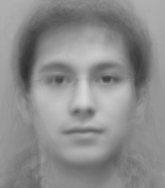

In [3]:
from IPython.display import Image
from image import image2file

path = 'centroid_face.png'
image2file(vec2image(a), path)
Image(filename=path)

In [4]:
centered_face_images = {i: face_images[i] - a for i in range(20)}

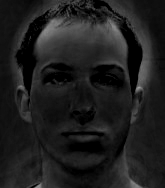

In [5]:
path = 'centered_face_01.png'
image2file(vec2image(centered_face_images[0]), path)
Image(filename=path)

In [6]:
# cleanup
!rm centroid_face.png centered_face_01.png

**Task 11.6.3:** Construct a matrix $A$ whose rows are the centered image vectors. The procedure `factor(A)` defined in the module `svd` returns an SVD of $A$, a triple ($U$, $\Sigma$, $V$) such that $A = U\Sigma V^T$. Note that the row space of $A$ equals the row space of $V^T$, i.e. the column space of $V$.

Then find an orthonormal basis for the 10-dimensional vector space that is closest to the twenty centered face image vectors. (The vectors of this basis are called _eigenfaces_.) You can use the SVD together with procedures from `matutil`.

In [7]:
from matutil import rowdict2mat

A = rowdict2mat(centered_face_images)

In [8]:
from svd import factor

U, Sigma, V = factor(A)

In [9]:
from matutil import mat2coldict, coldict2mat

V_cols = mat2coldict(V)
V_10 = coldict2mat([V_cols[i] for i in range(10)]) # the columns of this matrix are the 10d orthonormal basis.

**Task 11.6.4:** Write a procedure `projected_representation(M, x)` with the following spec:
* _input:_ a matrix `M` with orthonormal rows and a vector `x` such that the domain of `x` equals the column-label set of `M`
* _output:_ The coordinate representation of the projection $\boldsymbol{x}^{\|V}$ in terms of the rows of `M`, where $V$ = Row `M`

To help you debug, the module `eigenfaces` defines a matrix `test_M` and a vector `test_x`. Applying `projected_representation` to those results in `{0: 21.2132..., 1: 11.5470...}`

In [10]:
def projected_representation(M, x):
    return M * x

In [11]:
from eigenfaces import test_M, test_x

In [12]:
print(test_M)


           0      1
     --------------
 0  |  0.707  0.577
 1  |  0.707 -0.577
 2  |      0  0.577



In [13]:
print(test_x) # hmm, the domain of this vec is the _row label_ set of `test_M`, not the _column label_ set :(

# I don't know what's wrong - the spec, the description or the test.  But I'm keeping the spec (`x`'s domain equals the column-label set of M) and transposing the input


  0  1  2
---------
 10 20 30


In [14]:
projected_representation(test_M.transpose(), test_x)

Vec({0, 1},{0: 21.213203435596423, 1: 11.547005383792516})

**Task 11.6.5:** Write a procedure `projection_length_squared(M, x)` with the following spec:
* _input:_ a matrix `M` with orthonormal rows and a vector `x`, such that the label-set of `x` equals the column-labels of `M`.
* _output:_ The square of the norm of the projection of `x` into the space spanned by the rows of `M`.

Applying the procedure with `test_x`, `test_M` gives 583.33...

In [15]:
def projection_length_squared(M, x):
    rep = projected_representation(M, x)
    return rep * rep # norm is preserved when multiplying by an orthonormal matrix

In [16]:
projection_length_squared(test_M.transpose(), test_x)

583.3333333333333

**Task 11.6.6:** Write a procedure `distance_squared(M, x)` with the following spec:
* _input:_ a matrix `M` with orthonormal rows and a vector `x`, such that the label-set of `x` equals the column-labels of `M`.
* _output:_ the square of the distance from `x` to the vector space spanned by the rows of `M`.

Applying the procedure with `test_x`, `test_M` gives 816.66...

In [17]:
def distance_squared(M, x):
#    print('column labels: ', M.D[1])
#    print('label-set: ', x.D)
    return x * x - projection_length_squared(M, x)

In [18]:
distance_squared(test_M.transpose(), test_x)

816.6666666666667

**Task 11.6.7:** We will use the `distance_squared` procedure to classify images. First let's consider the images we already know to be faces. Compute the list consisting of their distances from the subspace of chosen eigenfaces (remember to work with the centered image vectors). Why are these distances not zero?

In [19]:
# based on wording of later questions, I'm acutally going to compute the _squared_ distances from the subspace
centered_face_distances_squared = [distance_squared(V_10.transpose(), centered_face_images[i]) for i in range(len(centered_face_images))]

**Task 11.6.8:** Next, for each unclassified image vector, center the vector by subtracting the average face vector, and find the squared distance of the centered image vector from the subspace of eigenfaces you found in Problem 11.6.3. Based on the distances you found, estimate which images are faces and which are not.

In [20]:
unclassified_images = {i: image2vec(color2gray(file2image("unclassified/img%02d.png" % i))) for i in range(10)}

In [21]:
centered_unclassified_images = {i: unclassified_images[i] - a for i in range(len(unclassified_images))}

In [22]:
centered_unclassified_distances_squared = [distance_squared(V_10.transpose(), centered_unclassified_images[i]) for i in range(len(centered_unclassified_images))]

In [23]:
centered_face_distances_squared

[7875252.445505843,
 15967960.02750402,
 3259398.756933272,
 5210603.898405939,
 1847965.6327982098,
 1810184.7401313484,
 1761404.1955005527,
 3856712.7529562786,
 9287329.099896718,
 10214670.986111235,
 5828238.601968482,
 2903087.9941666275,
 13112729.09677781,
 6004777.866640776,
 7015996.399822302,
 10152689.995303188,
 9139143.193325864,
 6456711.985581577,
 11883163.521836665,
 7480047.108550295]

In [24]:
centered_unclassified_distances_squared

[57720680.49132399,
 38634036.00224697,
 24887035.898887087,
 32050737.12518114,
 23638964.221357413,
 38061457.94465537,
 106934635.94739082,
 42743960.4505001,
 102195871.21915068,
 90226441.68966025]

In [25]:
# Let's use as a threshold 2.5X the _max_ of the known squared face-vector distances. (I got this from trying a few different values.)
threshold_distance_squared = max(centered_face_distances_squared) * 2.5

is_face_estimate_mask = [distance_squared < threshold_distance_squared for distance_squared in centered_unclassified_distances_squared]

**Task 11.6.9:** Display each of the unclassified images to check your estimate. Are the squared distances of non-faces indeed greater than those for faces?

What is the single threshold value you would choose to decide if a given image is a face or not?

In [26]:
from IPython.core.display import HTML 
path_format = 'unclassified/img%02d.png'

n = len(unclassified_images)

HTML('\n'.join(["<div style=\"display: flex\"><div style=\"display: inline-flex; margin-right: auto\">Predicted as face</div><div style=\"display: inline-flex; margin-right: auto\">Predicted as not-a-face</div></div>"] + ["<div style=\"display: flex\"><img style=\"display: inline-flex\" src=\"" + ('faces/img%02d.png' % i) + "\"><img style=\"display: inline-flex; margin: auto\" src=\"" + (path_format % j) + "\"></div>" for i,j in zip([i for i in range(n) if is_face_estimate_mask[i]], [j for j in range(n) if not is_face_estimate_mask[j]])]))

The chosen value of 2.5X the _max_ of the squared vector differences of the training face vectors turns out to be a perfect classifier for these test cases (or really validation cases, since I used the output to change the threshold hyperparameter).  However, it is a close call since 2X is too restrictive and 3X is too lenient.

**Task 11.6.10:** Now that we have constructed our classifier, let's get a closer look at the eigenfaces. It is interesting to check how much a face projected onto the subspace of eigenfaces resembles the original image. Write a procedure `project(M, x)`:
* _input:_ an orthogonal matrix `M` and a vector `x`, such that `x`'s labels are the same as `M`'s row labels
* _output:_ the projection of `x` into the space spanned by the rows of `M`.

In [27]:
def project(M, x):
    return M * projected_representation(M.transpose(), x)

In [28]:
project(test_M, test_x)

Vec({0, 1, 2},{0: 21.666666666666664, 1: 8.333333333333329, 2: 6.666666666666668})

**Task 11.6.11:** Display the projections of various faces, and compare them to the original face (do not forget to add the average face vector to centered image vectors before displaying them). Do the projections resemble the originals?

In [29]:
for i in range(5): # let's see five comparisons
    tmp_path = 'projected_face_%02d.png' % i
    image2file(vec2image(project(V_10, centered_face_images[i]) + a), tmp_path)

HTML('\n'.join(["<div style=\"display: flex\"><div style=\"display: inline-flex; margin-right: auto\">Original</div><div style=\"display: inline-flex; margin-right: auto\">Projected</div></div>"] + ["<div style=\"display: flex\"><img style=\"display: inline-flex\" src=\"" + ('faces/img%02d.png' % i) + "\"><img style=\"display: inline-flex; margin: auto\" src=\"" + ('projected_face_%02d.png' % i) + "\"></div>" for i in range(5)]))

**Task 11.6.12:** Display the projection of a non-face image and compare it to the original. Does the projection resemble a face? Can you explain?

In [30]:
for i in range(10):
    if not is_face_estimate_mask[i]:
        tmp_path = 'projected_nonface_%02d.png' % i
        image2file(vec2image(project(V_10, centered_unclassified_images[i]) + a), tmp_path)

In [31]:
HTML('\n'.join(["<div style=\"display: flex\"><div style=\"display: inline-flex; margin-right: auto\">Original</div><div style=\"display: inline-flex; margin-right: auto\">Projected</div></div>"] + ["<div style=\"display: flex\"><img style=\"display: inline-flex\" src=\"" + ('unclassified/img%02d.png' % i) + "\"><img style=\"display: inline-flex; margin: auto\" src=\"" + ('projected_nonface_%02d.png' % i) + "\"></div>" for i in range(10) if not is_face_estimate_mask[i]]))

What is interesting here is that the projections of non-faces to the span of our 10d orthonormal basis for the training faces _do in fact resemble faces_ (albeit weird cloudy combinations of many faces).  This is because although the original vector is far from resembling a face, all of the vectors in the span of our orthonormal basis _should_ and _do_ resemble faces, since they are lineaer combinations of the basis vectors that _best estimate_ the non-faces.

However, they do not look as crisp as projecting actual faces into this space, since the nearest estimates are very far from the target space of non-faces.

In [32]:
# cleanup
#!rm *.png

## 11.7 Review questions

**What is one way to measure the distance between two matrices with the same row-labels and column-labels?**

One way is to take the Frobeneus norm of the matrix of the difference between the two matrices.

**What are the singular values of a matrix? What are the left singular vectors and the right singular vectors?**

The right singular vectors $\boldsymbol{v}_i$ of a matrix are the mutually orthogonal norm one vectors that span the row space of the matrix.

The singular values $\sigma_i$ are the norms of the projections of the matrix rows onto the singular values (defined as $\|\boldsymbol{v}_1\|$).

The right singular vectors $\boldsymbol{u}_i$ are defined such that $\sigma_i\boldsymbol{u}_i = A\boldsymbol{v}_i$.

**What is the singular value decomposition (SVD) of a matrix?**

The SVD of a matrix is the decomposition of the matrix into its left singular vectors, singular values and right singular vectors.

**Given vectors $\boldsymbol{a}_1, ..., \boldsymbol{a}_m$, how can we find a one-dimensional vector space closest to $\boldsymbol{a}_1, ..., \boldsymbol{a}_m$? Closest in what sense?**

We find the space spanned by the first right singular vector of the vectors (after subracting by their centroid), which is chosen to maximize the first singular value (defined above). This vector space will be closest in the sense that projecting the centered vectors onto the space preserves their variance (spread) the most. (Can be thought of as a line _most_ orthogonal two a set of 2-vectors in the 2d case.)

**Given in addition an integer $k$, how can we find the $k$-dimentional vector space closest to $\boldsymbol{a}_1, ..., \boldsymbol{a}_m$?**

Repeat the process for finding the first such space $k - 1$ more times, only considering the vector basis orthogonal to the first space (until the span is the zero vector).

**Given a matrix $A$ and an integer $k$, how can we find the rank-at-most-$k$ matrix closest to $A$?**

The matrix $\tilde{A}$ matrix closest to $A$ with rank at-most $k$ is $U\Sigma V^T$ (where $U$, $\Sigma$ and $V$ are the results of the SVD of $A$.

**What use is finding this matrix?**

This matrix can be used whenever a lower-dimensional approximation is needed that retains salient characteristics of the original row space.  It can be used for dimensionality reduction and compression, for classification, lower-dimensional visualization, feature engineering, robust predictions and many other things.

**How can SVD be used to solve a least-squares problem?**

Using the results of SVD, the same $\hat{\boldsymbol{x}}$ that minimizes $\|A\boldsymbol{x} - \boldsymbol{b}\|$ is equal to $V\Sigma^{-1}U^T\boldsymbol{b}$.

## 11.8 Problems

**Problem 11.8.1:** Write a proceure `squared_Frob(A)` that, given a `Mat` over $\mathbb{R}$, returns the square of its Frobenius norm.

Test your procedure. For example,

$\left\|\begin{bmatrix}1 &2 &3 &4\\-4 &2 &-1 &0\end{bmatrix}\right\|^2_F = 51$

In [33]:
def squared_Frob(A):
    return sum([v ** 2 for v in A.f.values()])

In [34]:
from matutil import listlist2mat
squared_Frob(listlist2mat([[1, 2, 3, 4], [-4, 2, -1, 0]]))

51

**Problem 11.8.2:** Give a numerical counterexample to the following:

Let $A$ be a matrix, and let $Q$ be a column-orthogonal matrix. If $AQ$ is defined then $\|AQ\|_F = \|A\|_F$.

In [35]:
from orthonormalization import orthonormalize
from matutil import rowdict2mat
from vecutil import list2vec

L = [list2vec([1, 2]), list2vec([1, 1]), list2vec([1, -1])]
Q = rowdict2mat(orthonormalize(L))
print('Q:', Q)
A = listlist2mat([[1, -1, 1]])
print('A:', A)
print('squared_Frob(A * Q)', squared_Frob(A * Q))
print('squared_Frob(A)', squared_Frob(A))

Q: 
           0      1
     --------------
 0  |  0.447  0.894
 1  |  0.894 -0.447
 2  |      0     -1

A: 
       0  1 2
     --------
 0  |  1 -1 1

squared_Frob(A * Q) 0.3167184270002523
squared_Frob(A) 3


**Problem 11.8.3:** Here is a matrix $A$ and the SVD $A = U\Sigma V^T$:

$A = \begin{bmatrix}1 &0\\0 &2\\0 &0\end{bmatrix}$, $U = \begin{bmatrix}0 &1\\1 &0\\0 &0\end{bmatrix}$, $\Sigma = \begin{bmatrix}2 &0\\0 &1\end{bmatrix}$, $V^T = \begin{bmatrix}0 &1\\1 &0\end{bmatrix}$

1. For the vector $\boldsymbol{x} = (1, 2)$, compute $V^T\boldsymbol{x}, \Sigma(V^T\boldsymbol{x})$ and $U(\Sigma(V^T\boldsymbol{x}))$.

In [36]:
x = list2vec([1, 2])
V_T = listlist2mat([[0, 1], [1, 0]])
Sigma = listlist2mat([[2, 0], [0, 1]])
U = listlist2mat([[0, 1], [1, 0], [0, 0]])

In [37]:
print(V_T * x)


 0 1
----
 2 1


In [38]:
print(Sigma * (V_T * x))


 0 1
----
 4 1


In [39]:
print(U * (Sigma * (V_T * x)))


 0 1 2
------
 1 4 0


In [40]:
A = listlist2mat([[1, 0], [0, 2], [0, 0]])
print(A * x)


 0 1 2
------
 1 4 0


2\. For the vector $\boldsymbol{x} = (2, 0)$, compute $V^T\boldsymbol{x}, \Sigma(V^T\boldsymbol{x})$ and $U(\Sigma(V^T\boldsymbol{x}))$.

In [41]:
x = list2vec([2, 0])
print(V_T * x)


 0 1
----
 0 2


In [42]:
print(Sigma * (V_T * x))


 0 1
----
 0 2


In [43]:
print(U * (Sigma * (V_T * x)))


 0 1 2
------
 2 0 0


In [44]:
print(A * x)


 0 1 2
------
 2 0 0


**Problem 11.8.4:** Each of the matrices below is shown with row and column labels. For each matrix, calculate the singular value decomposition. Don't use an algorithm; just use cleverness and your understanding of the SVD. The rows and columns of $\Sigma$ should be labeled by consecutive integers 0, 1, 2, ... so $\Sigma[0, 0]$ is the first singular value, etc. Verify your answer is correct by multiplying out the matrices comprising the SVD.

1. $A = \begin{bmatrix}3 &0\\0 &-1\end{bmatrix}$

2. $B = \begin{bmatrix}3 &0\\0 &4\end{bmatrix}$

3. $C = \begin{bmatrix}0 &4\\0 &0\\0 &0\end{bmatrix}$

In [45]:
#1:
V = listlist2mat([[1, 0], [0, 1]])
Sigma = listlist2mat([[3, 0], [0, 1]])
U = listlist2mat([[1, 0],[0, -1]])
print(U * (Sigma * (V.transpose())))


       0  1
     ------
 0  |  3  0
 1  |  0 -1



In [46]:
# just for fun, here's another couple decompositions for #1:
V = listlist2mat([[-1, 0], [0, 1]])
Sigma = listlist2mat([[3, 0], [0, 1]])
U = listlist2mat([[-1, 0],[0, -1]])
print(U * (Sigma * (V.transpose())))

V = listlist2mat([[-1, 0], [0, 1]])
Sigma = listlist2mat([[-3, 0], [0, 1]])
U = listlist2mat([[1, 0],[0, -1]])
print(U * (Sigma * (V.transpose())))


       0  1
     ------
 0  |  3  0
 1  |  0 -1


       0  1
     ------
 0  |  3  0
 1  |  0 -1



In [47]:
#2:
V = listlist2mat([[1, 0], [0, 1]])
Sigma = listlist2mat([[3, 0], [0, 4]])
U = listlist2mat([[1, 0],[0, 1]])
print(U * (Sigma * (V.transpose())))


       0 1
     -----
 0  |  3 0
 1  |  0 4



In [48]:
#3:
V = listlist2mat([[0, 1], [1, 0]])
Sigma = listlist2mat([[4, 0], [0, 0]])
U = listlist2mat([[1, 0],[0, 1], [0, 0]])
print(U * (Sigma * (V.transpose())))

# another for 3:
V = listlist2mat([[0, 1], [-1, 0]])
Sigma = listlist2mat([[4, 0], [0, 0]])
U = listlist2mat([[-1, 0],[0, 1], [0, 0]])
print(U * (Sigma * (V.transpose())))


       0 1
     -----
 0  |  0 4
 1  |  0 0
 2  |  0 0


       0 1
     -----
 0  |  0 4
 1  |  0 0
 2  |  0 0



**Problem 11.8.5:** For each of the following matrices find the closest rank-2 matrix. For an $m \times n$ matrix, provide your answer as a product of two matrices, $HG$, where $G$ is an $m \times 2$ matrix and $H$ is a $2 \times n$ matrix.

1. $A = \begin{bmatrix}1 &0 &1\\0 &2 &0\\1 &0 &1\\0 &1 &0\end{bmatrix}$

  $U = \begin{bmatrix}0 &-\sqrt{0.5} &0\\\sqrt{0.8} &0 &\sqrt{0.2}\\0 &-\sqrt{0.5} &0\\\sqrt{0.2} &0 &-\sqrt{0.8}\end{bmatrix}$, $\Sigma = \begin{bmatrix}\sqrt{5} &0 &0\\0 &2 &0\\0 &0 &0\end{bmatrix}$, $V^T = \begin{bmatrix}0 &1 &0\\-\sqrt{0.5} &0 &-\sqrt{0.5}\\\sqrt{0.5} &0 &-\sqrt{0.5}\end{bmatrix}$
2. $B = \begin{bmatrix}0 &0 &1\\0 &0 &1\\1 &0 &0\\0 &1 &0 \end{bmatrix}$

  $U = \begin{bmatrix}\frac{\sqrt{2}}{2} &0 &0\\\frac{\sqrt{2}}{2} &0 &0\\0 &0 &-1\\0 &-1 &0\end{bmatrix}$, $\Sigma = \begin{bmatrix}\sqrt{2} &0 &0\\0 &1 &0\\0 &0 &1\end{bmatrix}$, $V^T = \begin{bmatrix}0 &0 &1\\0 &-1 &0\\-1 &0 &0\end{bmatrix}$

For each of these problems, for the closest rank-2 approximation, we can easily decompose the answer into _three_ matrices, $\tilde{U}$, $\tilde{\Sigma}$ and $\tilde{V}^T$ by taking the first two columns of $U$, the first two diagonal entries of $\Sigma$ and the first two rows of $V^T$.

Then $H = \tilde{U}$ and what remains to get the solution into the requested form is just to multiply to get $G = \tilde{\Sigma}\tilde{V}^T$

1.

$H = \tilde{U} = \begin{bmatrix}0 &-\sqrt{0.5}\\\sqrt{0.8} &0\\0 &-\sqrt{0.5}\\\sqrt{0.2} &0\end{bmatrix}$, $G = \tilde{\Sigma}\tilde{V}^T = \begin{bmatrix}\sqrt{5} &0\\0 &2\end{bmatrix} \begin{bmatrix}0 &1 &0\\-\sqrt{0.5} &0 &-\sqrt{0.5}\end{bmatrix} = \begin{bmatrix}0 &\sqrt{5} &0\\-\frac{2}{\sqrt{2}} &0 &-\frac{2}{\sqrt{2}}\end{bmatrix}$

2.

$H = \tilde{U} = \begin{bmatrix}\frac{\sqrt{2}}{2} &0\\\frac{\sqrt{2}}{2} &0\\0 &0\\0 &-1\end{bmatrix}$, $G = \tilde{\Sigma}\tilde{V}^T = \begin{bmatrix}\sqrt{2} &0\\0 &1\end{bmatrix} \begin{bmatrix}0 &0 &1\\0 &-1 &0\end{bmatrix} = \begin{bmatrix}0 &0 &\sqrt{2}\\0 &-1 &0\end{bmatrix}$

**Problem 11.8.6:** Consider the following computational problem:

Computing a low-rank representation of a low-rank matrix

* _input:_ a matrix $A$ and a positive integer $k$
* _output:_ a pair of matrices $B$, $C$ such that $A = BC$ and $B$ has at most $k$ columns, or 'FAIL' if there is no such pair

We can get an algorithm for this problem by using the SVD of $A$. However, there is also an algorithm using only the tools we have studied in previous chapters.

Describe such an algorithm, give pseudo-Python for it, and explain why it works.

In [49]:
from QR import factor as QRfactor
from independence import rank
from matutil import mat2coldict, rowdict2mat, coldict2mat, mat2rowdict
from orthogonalization import aug_orthogonalize

def low_rank_factorization(A, k):
    if k < rank(list(mat2coldict(A).values())):
        return 'FAIL'
    vstarlist, sigma_vecs = aug_orthogonalize(list(mat2coldict(A).values()))
    # the second part of this just says: "Make a matrix out of the first `k` _rows_ of the matrix with columns `sigma_vecs`"
    return coldict2mat(vstarlist[:k]), rowdict2mat(list(mat2rowdict(coldict2mat(sigma_vecs)).values())[:k])

I'm not _positive_ the above will work for any generic matrix meeting the criteria. But it seems right.  Basically, this approach should work because if $B$ and $C$ exist, then $A$ must have rank $>= k$.  Then we are just saying, orthogonalize $A$ by its columns and return 1) the only _nonzero_ columns of $A$, and 2) the matrix with coefficients needed to multiply by these columns to get back to the original matrix.

In [50]:
A = listlist2mat([[1, 0, 1], [0, 2, 0], [1, 0, 1], [0, 1, 0]])
B, C = low_rank_factorization(A, 2)
print(B)
print(C)
print(B * C)


       0 1
     -----
 0  |  1 0
 1  |  0 2
 2  |  1 0
 3  |  0 1


       0 1 2
     -------
 0  |  1 0 1
 1  |  0 1 0


       0 1 2
     -------
 0  |  1 0 1
 1  |  0 2 0
 2  |  1 0 1
 3  |  0 1 0



**Problem 11.8.7:** Write a Python procedure `SVD_solve(U, Sigma, V, b)` with the following spec:
* _input:_ the SVD of a square matrix `A = U Sigma V^T`. You can assume that `U`, `Sigma`, and `V` are square matrices and are legal to multiply together.
* _output:_ vector `x` such that `(U * Sigma * V.transpose()) * x = b` or `'FAIL'` if `A` is not invertible.

Your procedure should not use any modules other than `mat`.

Test your procedure with the following example:

The matrix $A = \begin{bmatrix}1 &1 &0\\1 &0 &1\\0 &1 &1\end{bmatrix}$ has the following SVD $A = U\Sigma V^T$:

$U = \begin{bmatrix}-\frac{1}{\sqrt{3}} &\frac{1}{\sqrt{6}} &\frac{1}{\sqrt{2}}\\-\frac{1}{\sqrt{3}} &\frac{1}{\sqrt{6}} &-\frac{1}{\sqrt{2}}\\-\frac{1}{\sqrt{3}} &-\frac{2}{\sqrt{6}} &0\end{bmatrix}, \Sigma = \begin{bmatrix}2 &0 &0\\0 &1 &0\\0 &0 &1\end{bmatrix}, V^T = \begin{bmatrix}-\frac{1}{\sqrt{3}} &-\frac{1}{\sqrt{3}} &-\frac{1}{\sqrt{3}}\\\frac{2}{\sqrt{6}} &-\frac{1}{\sqrt{6}} &-\frac{1}{\sqrt{6}}\\0 &\frac{1}{\sqrt{2}} &-\frac{1}{\sqrt{2}}\end{bmatrix}$

Let $\boldsymbol{b} = [2,3,3]$.

In [51]:
from mat import Mat

def SVD_solve(U, Sigma, V, b):
    return V * (Mat(Sigma.D, {k: 1 / v for k, v in Sigma.f.items() if v != 0}) * (U.transpose() * b))

In [52]:
A = listlist2mat([[1, 1, 0], [1, 0, 1], [0, 1, 1]])
U = listlist2mat([[-1/(3 ** 0.5), 1/(6 ** 0.5), 1/(2 ** 0.5)], [-1/(3 ** 0.5), 1/(6 ** 0.5), -1/(2 ** 0.5)], [-1/(3 ** 0.5), -2/(6 ** 0.5), 0]])
Sigma = listlist2mat([[2, 0, 0], [0, 1, 0], [0, 0, 1]])
V_T = listlist2mat([[-1/(3 ** 0.5), -1/(3 ** 0.5), -1/(3 ** 0.5)], [2/(6 ** 0.5), -1/(6 ** 0.5), -1/(6 ** 0.5)], [0, 1/(2 ** 0.5), -1/(2 ** 0.5)]])
b = list2vec([2, 3, 3])

In [53]:
x = SVD_solve(U, Sigma, V_T.transpose(), b)

In [54]:
print(x)


 0 1 2
------
 1 1 2


In [55]:
print((U * Sigma * V_T) * x) # checks out


 0 1 2
------
 2 3 3
